In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from invagination.morphometry import (parse_ply, 
                                      get_borders, 
                                      get_morphometry,
                                      get_ventral_patch,
                                      analyse,
                                      grided_graph,
                                      color_plot_silico,
                                      color_plot_vivo)


In [5]:
base_dir = Path('/media/data/Sophie/Analyses/20180328')
base_dir = '/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo'

print('Data sub-directories:')
print('\t', *os.listdir(base_dir), sep='\n\t')
print('----------')
data_dirs = []
for tree in os.walk(base_dir):
    if not tree[1]: # only dir without subdirs
        data_dirs.append((Path(tree[0]), tree[-1]))
data_dir = data_dirs[3][0]
data_files = [f for f in data_dirs[3][1] if f.endswith('.ply')]
print('Data directory:')
print(data_dir)

print('\t', *data_files, sep='\n\t')



Data sub-directories:
	
	20161108
	20170519
	20170531
----------


IndexError: list index out of range

In [3]:
collected_vivo = {}

for data_dir in data_dirs:
    print(f'Treating {data_dir[0]}')
    figures, axes = None, None
    plys = [f for f in data_dir[1] if f.endswith('.ply')]
    for data_file in plys:
        basename = '_'.join((data_dir[0].parent.stem.replace(' ', ''),
                             Path(plys[0]).stem))
        try:
            centers, figures, axes = analyse(data_dir[0], data_file,
                                             basename=basename,
                                             figures=figures, 
                                             axes=axes,
                                             show=True,
                                             save=True)
            collected_vivo[basename] = centers
        except Exception as e:
            print(f'Failed for {basename}')
            print(type(e))
            print(e)

    plt.close('all')

In [ ]:
with open(data_dir[0]/plys[0], 'r+') as fh:
    datasets = parse_ply(fh, read_faces=True)

borders = get_borders(datasets)
centers = get_morphometry(borders)

In [ ]:
fig, ax = color_plot_vivo(datasets, centers, 'area', ax=None, coords='yx')
fig.set_size_inches(12, 6)

## Morphometry from simulation


In [37]:
from tyssue import Sheet, SheetGeometry, config
from tyssue.io import hdf5
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view

n_delaminated = [0, 10, 60, 175]

sim_data_dirs = Path('/media/data/Sophie/Simulations/')
sim_data_dirs = Path('/home/admin-suz/Documents/short_simul/2018-09-07_TEST0/1.08_contractility_5_critical_area_30_radialtension_0')
hf5s = {}
for data_dir in os.walk(sim_data_dirs) :
    stores = [f for f in data_dir[2] if f.endswith('hf5')]
    stores.sort()
    csvs = [f for f in data_dir[2] if f.endswith('csv')]
    time_index = np.arange(0,200)
    if len(stores):

        """times = pd.read_csv(Path(data_dir[0])/csvs[0], index_col=0)['end']
        times = times[times > 0].sort_values().astype(int)
        time_index = times.iloc[n_delaminated]
        """
        hf5names = [stores[0]]
        hf5names.extend([stores[t] for t in time_index])
        hf5s[data_dir[0]] = hf5names


In [34]:
dir0, dir1 = hf5s
hf5s[dir0], hf5s[dir1]

ValueError: too many values to unpack (expected 2)

In [35]:
fname = Path(dir0)/hf5s[dir0][1]
sheet = get_ventral_patch(fname)
sim_borders = sheet.upcast_srce(sheet.vert_df[sheet.coords])
sim_borders['label'] = sheet.edge_df['face']
sim_centers = get_morphometry(sim_borders)

KeyError: 1

In [36]:
hf5s

{'/home/admin-suz/Documents/short_simul/2018-09-07_TEST0/1.08_contractility_5_critical_area_30_radialtension_0': ['invagination_0000.hf5',
  'invagination_0000.hf5',
  'invagination_0001.hf5',
  'invagination_0002.hf5',
  'invagination_0003.hf5',
  'invagination_0004.hf5',
  'invagination_0005.hf5',
  'invagination_0006.hf5',
  'invagination_0007.hf5',
  'invagination_0008.hf5',
  'invagination_0009.hf5',
  'invagination_0010.hf5',
  'invagination_0011.hf5',
  'invagination_0012.hf5',
  'invagination_0013.hf5',
  'invagination_0014.hf5',
  'invagination_0015.hf5',
  'invagination_0016.hf5',
  'invagination_0017.hf5',
  'invagination_0018.hf5',
  'invagination_0019.hf5',
  'invagination_0020.hf5',
  'invagination_0021.hf5',
  'invagination_0022.hf5',
  'invagination_0023.hf5',
  'invagination_0024.hf5',
  'invagination_0025.hf5',
  'invagination_0026.hf5',
  'invagination_0027.hf5',
  'invagination_0028.hf5',
  'invagination_0029.hf5',
  'invagination_0030.hf5',
  'invagination_0031.hf5

Treating /home/admin-suz/Documents/short_simul/2018-09-07_TEST0/1.08_contractility_5_critical_area_30_radialtension_0


KeyboardInterrupt: 

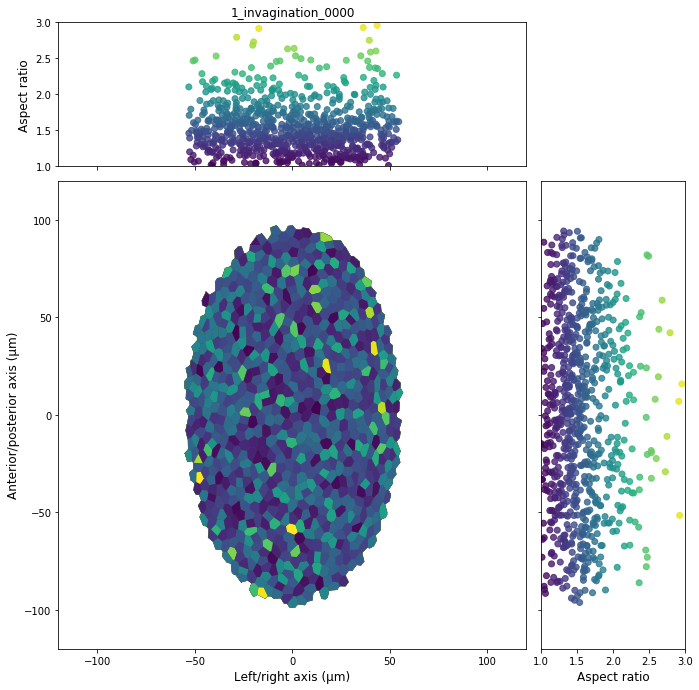

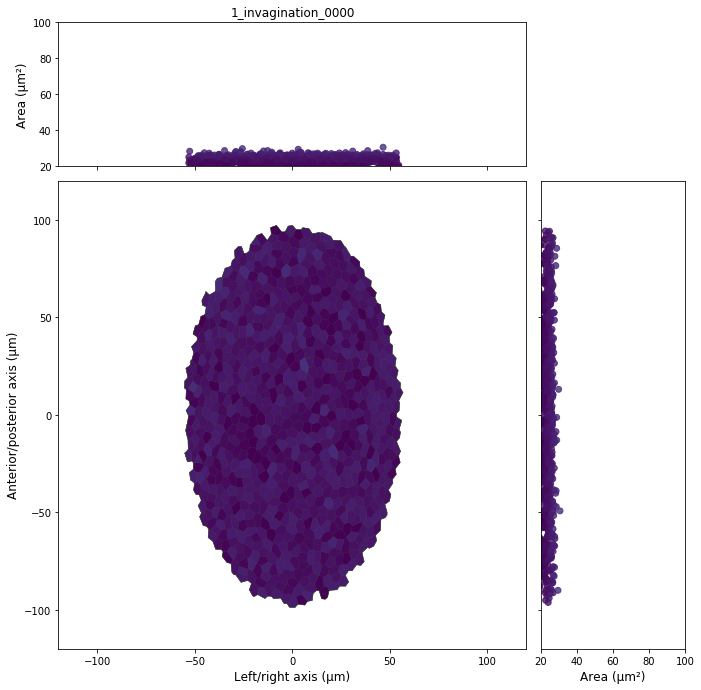

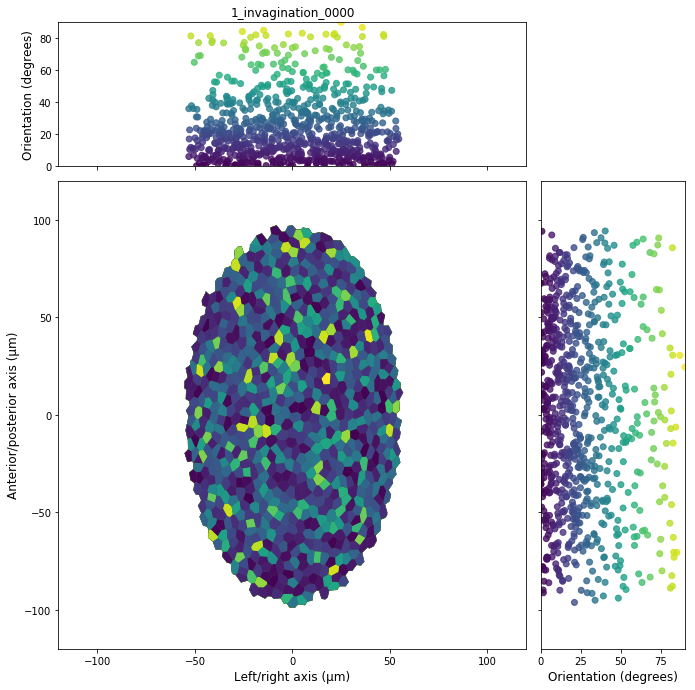

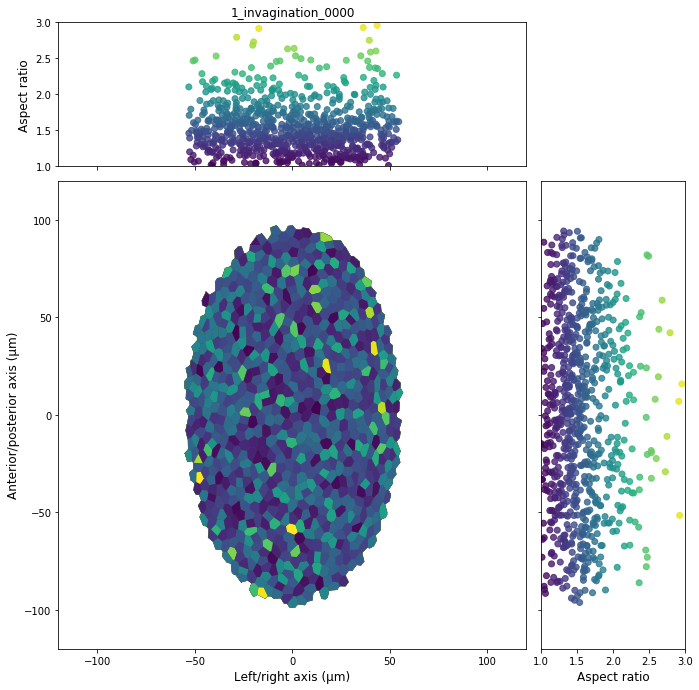

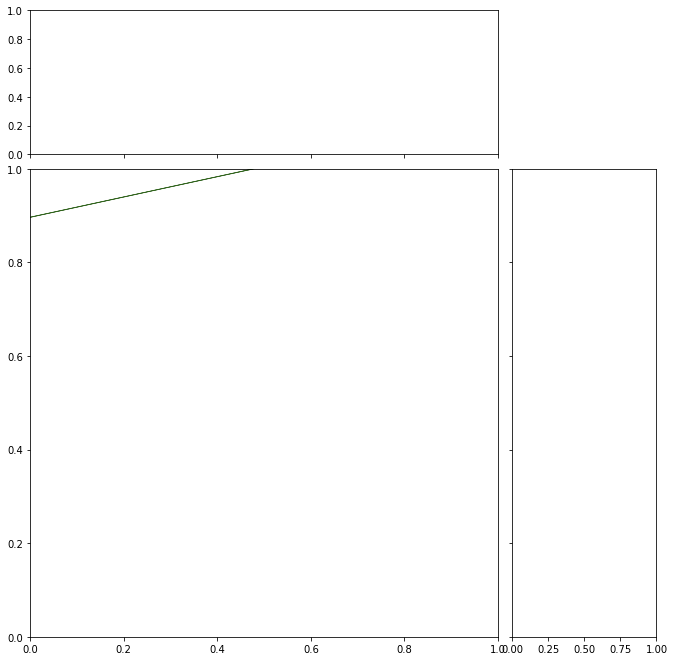

In [38]:
collected_silico = {}
for base_dir, stores in hf5s.items():
    base_dir = Path(base_dir)
    print(f'Treating {base_dir.as_posix()}')
    for store in stores:
        basename = '_'.join((base_dir.stem, Path(store).stem))
        centers, figures, axes = analyse(base_dir, store,
                                         basename=basename,
                                         figures=None, 
                                         axes=None,
                                         show=True,
                                         save=True)
        collected_silico[basename] = centers
    plt.close('all')

In [39]:
print(*collected_silico.keys(), sep='\n')

1_invagination_0000


In [ ]:
print(*collected_vivo.keys(), sep='\n')

In [ ]:
centers = collected_silico['propagation_1_invagination_0000']

In [ ]:
centers = collected_vivo['20170519-embPHmcherry3_20170519_T65']

In [ ]:
centers.head()

NameError: name 'rol' is not defined

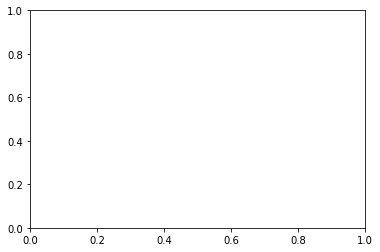

In [40]:
fig, ax = plt.subplots()

rol.sort_values('x', inplace=True)
ax.scatter(centers.x - centers.x.mean(), centers.area, alpha=0.1)


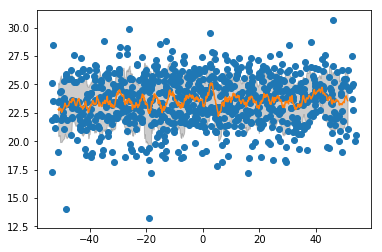

In [41]:
fig, ax = plt.subplots()
rol = centers[['x', 'area']].sort_values('x').rolling(window=20)
ax.plot(centers.x - centers.x.mean(), centers.area, 'o')
ax.plot(rol.x.mean() - centers.x.mean(), rol.area.mean())
ax.fill_between(rol.x.mean() - centers.x.mean(), 
                rol.area.mean()+rol.area.std(),
                rol.area.mean()-rol.area.std(), 
                color='k', alpha=0.2)


In [43]:
rollings_vivo = {name: centers.sort_values('x').rolling(window=20)
                 for name, centers in collected_vivo.items()}

rollings_silico = {name: centers.sort_values('x').rolling(window=20)
                   for name, centers in collected_silico.items()}
    


In [44]:
print(*rollings_silico.keys(), sep='\n')

1_invagination_0000


In [ ]:
print(*rollings_vivo.keys(), sep='\n')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


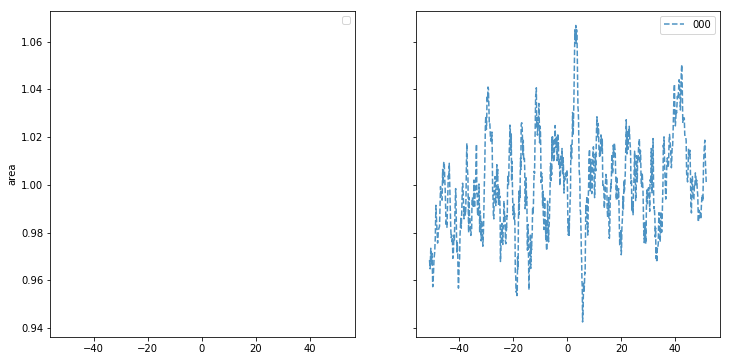

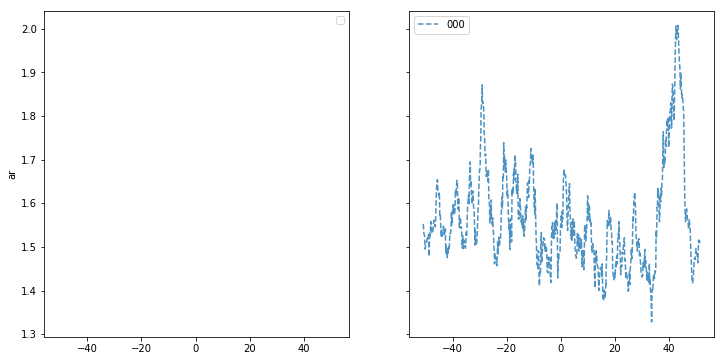

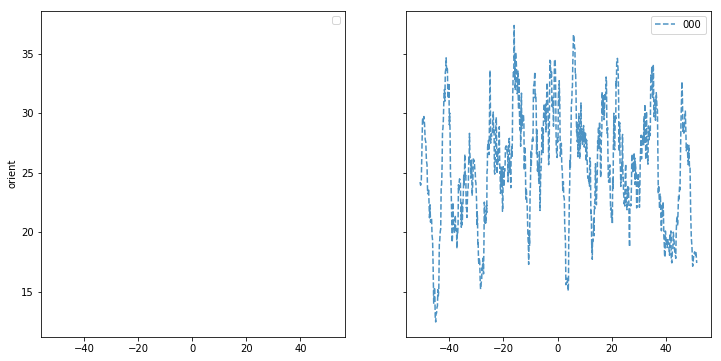

In [46]:
norm = True, False, False
for col, norm in zip(['area', 'ar', 'orient'], norm):

    fig, (ax_vivo, ax_silico) = plt.subplots(1, 2, sharex=True, sharey=True)
    for name, rol in rollings_vivo.items():
        time = name.split('T')[1][:3]
        if norm:
            y = rol[col].mean()/rol[col].mean().mean()
        else:
            y = rol[col].mean()
        ax_vivo.plot(rol.x.mean(), y,
                     label=time, alpha=0.8)

    for name, rol in rollings_silico.items():
        time = name.split('_')[-1][-3:]
        if norm:
            y = rol[col].mean()/rol[col].mean().mean()
        else:
            y = rol[col].mean()
        if col == 'ar':
            y = y.clip(upper=2.5)
        ax_silico.plot(rol.x.mean(), y, '--',
                       label=time, alpha=0.8)

    ax_silico.legend()
    ax_vivo.legend()
    ax_vivo.set_ylabel(col)
    plt.savefig(f'{col}_profiles.svg')
    fig.set_size_inches(12, 6)

In [ ]:
from scipy.stats import kde

In [ ]:
area_kde = kde.gaussian_kde(centers[['x', 'area']].T)

In [ ]:
n, xbins, ybins = np.histogram2d(centers['x'], centers['area'])

In [ ]:
h = centers.plot.hexbin('x', 'area', gridsize=20)

In [ ]:
xx, aa = np.meshgrid(np.linspace(-50, 50, 128), np.linspace(10, 40, 128))

grid = np.vstack([xx.ravel(), aa.ravel()])

In [ ]:
kde_plane = area_kde.evaluate(grid)

In [ ]:
max_area_idx = kde_plane.reshape((128, 128)).argmax(axis=0)

In [ ]:
max_areas =  np.linspace(10, 40, 128).take(max_area_idx)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(kde_plane.reshape((128, 128)))

In [ ]:

from scipy.interpolate import splrep, splev

In [ ]:
centers.sort_values('x', inplace=True)

In [ ]:
fig, ax = plt.subplots()
rol = centers.rolling(20).mean()

rol.sort_values('x', inplace=True)
ax.scatter(centers.x, centers.area, alpha=0.1)
ax.plot(rol.x, rol.area)

tck = splrep(centers['x'].values, 
             centers['area'].values,
             s=centers['area'].values.shape[0]*40)

xs = np.linspace(-45, 45, 100)
ax.plot(xs, splev(xs, tck))


In [ ]:
rol

## ply data structure details

In [ ]:
with open(data_dirs[0][0]/'20161108_T10.ply', 'r+') as fh:
    datasets = parse_ply(fh, read_faces=True)

fig, ax = plt.subplots()
datasets['background'] = datasets['vert'][datasets['vert'].label == 0]
datasets['membrane'] = datasets['vert'][datasets['vert'].label == -1]

f_527 = datasets["face"][datasets["face"].label==527]
v_527 = datasets['vert'].loc[set(f_527[["v0", "v1", "v2"]].values.ravel())]

ax.triplot(datasets['vert'].x,
           datasets['vert'].y, 
           triangles=f_527[['v0', 'v1', 'v2']],
           lw=0.2)

ax.scatter(v_527.x[v_527.label < 0], 
           v_527.y[v_527.label < 0],
           color='r', marker='o', s=1)

ax.scatter(datasets['background'].x, 
           datasets['background'].y,
           color='k', marker='.', s=1)

ax.scatter(datasets['membrane'].x, 
           datasets['membrane'].y,
           color='g', marker='.', s=1)

ax.set_aspect('equal')
#ax.set(aspect='equal',
#       xlim=(-50, -30),
#       ylim=(-50, -30), )
fig.set_size_inches(12, 12)


#### Reconstruct sheet from data

In [ ]:
f0 = borders[borders.label==12]
f1 = borders[borders.label==580]
e01 = borders[borders.neigh == frozenset((12, 580))]
fig, ax = plt.subplots()
ax.plot(f0.x, f0.y)
ax.plot(f0.x.iloc[0], f0.y.iloc[0], 'ko')
ax.plot(f1.x, f1.y)
ax.plot(f1.x.iloc[0], f1.y.iloc[0], 'ro')

ax.plot(e01.x, e01.y, '-+')
ax.set_aspect('equal')

fig.set_size_inches(10, 10)

In [ ]:
neighbour_faces = borders.groupby('vert').apply(
    lambda df: frozenset(df.label.values.astype(int)))
neighbour_faces.name = 'neigh'
neighbour_faces.sort_index(inplace=True)

borders['neigh'] = neighbour_faces.loc[borders.vert].values

In [ ]:
def _align(verts):
    centered = (verts[coords].values -
            verts[coords].mean(axis=0).values[np.newaxis, :])
    u, s, v = np.linalg.svd(centered,
                            full_matrices=False,
                            compute_uv=True)

    aligned = centered @ v.T
    aligned = pd.DataFrame(aligned,
                           index=verts.index,
                           columns=['r'+c for c in coords])
    return aligned

aligned = borders.groupby('label').apply(_align)
borders = pd.concat([borders, aligned], axis=1)
borders['theta'] = np.arctan2(borders.rx, borders.ry)
borders = borders.sort_values(['label', 'theta']).reset_index()

In [ ]:
from tyssue import Sheet, SheetGeometry, config
from tyssue.draw.plt_draw import quick_edge_draw



def _get_edge_indices(df):
    srtd = df.sort_values('theta')
    return pd.Series({'face': srtd.label.iloc[0],
                      'srce': srtd.vert.iloc[0],
                      'trgt': srtd.vert.iloc[-1]})

edge_df = borders.groupby(['label', 'neigh']).apply(_get_edge_indices).reset_index()
edge_df = edge_df[edge_df.neigh.apply(len) < 3] 
face_df = centers.loc[edge_df.label.unique()].copy()
vert_df = datasets['vert'].loc[set(edge_df[['srce', 'trgt']].values.ravel())].copy()



ty_datasets = {'vert': vert_df, 'face': face_df, 'edge': edge_df}

sheet = Sheet('from_ply', ty_datasets, config.geometry.flat_sheet())
sheet.reset_index()
sheet.reset_topo()
SheetGeometry.update_all(sheet)

to_flip = sheet.edge_df[sheet.edge_df['sub_vol'] < 0].index
sheet.edge_df.loc[to_flip, ['srce', 'trgt']] = sheet.edge_df.loc[to_flip, ['trgt', 'srce']]

SheetGeometry.update_all(sheet)

fig, ax = quick_edge_draw(sheet)
plt.savefig('extracted.svg')

In [ ]:
os.path.isdir()